# <font color='blue'>Abundant Power

Table of Content:

1. 'Unlimited' Source

2. EDA

3. Features

4. Predict electricity output

5. Identifying maintenance need


# 1. 'Unlimited' Source

# <font color='orange'>Solar power is an important form of renewable energy. Photovaltaic electricity of two power plants are monitored along with their ambient enviorment information. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#import optuna 
#import shap 
#import pickle

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from pathlib import Path

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score



# Importing Data

In [4]:
plant1_generation = pd.read_csv('../input/solar-power-generation-data/Plant_1_Generation_Data.csv')
plant1_weather = pd.read_csv('../input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')
plant2_generation = pd.read_csv('../input/solar-power-generation-data/Plant_2_Generation_Data.csv')
plant2_weather = pd.read_csv('../input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv')


# 2. EDA

In [5]:
plant1_generation.describe()
plant1_weather.describe()

,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3182.0,3182.000000,3182.000000,3182.000000
mean,4135001.0,25.531606,31.091015,0.228313
std,0.0,3.354856,12.261222,0.300836
min,4135001.0,20.398505,18.140415,0.000000
25%,4135001.0,22.705182,21.090553,0.000000
50%,4135001.0,24.613814,24.618060,0.024653
75%,4135001.0,27.920532,41.307840,0.449588
max,4135001.0,35.252486,65.545714,1.221652


In [6]:
plant1_weather.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [7]:
plant1_generation.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


# <font color='blue'> Source_Key refers to the specific inverter 
    that converts DC power generated by PV cells to AC powers that can transmit efficiently through long distance. 

# Basic dataframe info

In [8]:
plant1_generation.info()
plant2_generation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    67698 non-null  object 
 1   PLANT_ID     67698 non-null  int64  
 2   SOURCE_KEY   67698 non-null  object 
 3   DC_POWER     67698 non-null  float64
 4   AC_POWER     67698 non-null  float64
 5   DAILY_YIELD  67698 non-null  float64
 6   TOT

In [9]:
plant1_weather.info()
plant2_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3259 non-null   object 
 1   PLANT_ID             3259 non-null   int64  
 2   SOURCE_KEY           3259 non-null   object 
 3   AMBIENT_TEMPERATURE  3259 non-null   float64
 4   MODULE_TEMPERATURE 

# Features

In [10]:
plant1_generation.columns= ['dt_time', 'plant_id', 'source_key', 'dc_power', 'ac_power', 'daily_yield', 'total_yield']
plant1_weather.columns = ['dt_time', 'plant_id', 'source_key', 'amb_temp', 'mod_temp', 'irrad']
plant2_generation.columns = ['dt_time', 'plant_id', 'source_key', 'dc_power', 'ac_power', 'daily_yield', 'total_yield']
plant2_weather.columns = ['dt_time', 'plant_id', 'source_key', 'amb_temp', 'mod_temp', 'irrad']

In [11]:
dataframes=[plant1_generation,plant2_generation]

for i in dataframes:
    print('start date ',i.dt_time.min(), 'end date ',i.dt_time.max())

start date  01-06-2020 00:00 end date  31-05-2020 23:45
start date  2020-05-15 00:00:00 end date  2020-06-17 23:45:00


In [12]:
dataframes=[plant1_weather,plant2_weather]

for i in dataframes:
    print('start date ',i.dt_time.min(), 'end date ',i.dt_time.max())

start date  2020-05-15 00:00:00 end date  2020-06-17 23:45:00
start date  2020-05-15 00:00:00 end date  2020-06-17 23:45:00


# date time

In [13]:
plant1_generation['dt_time']= pd.to_datetime(plant1_generation['dt_time'],format='%d-%m-%Y %H:%M')
plant1_weather['dt_time']= pd.to_datetime(plant1_weather['dt_time'],format='%Y-%m-%d %H:%M:%S')
plant2_generation['dt_time']= pd.to_datetime(plant2_generation['dt_time'],format='%Y-%m-%d %H:%M')
plant2_weather['dt_time']= pd.to_datetime(plant2_weather['dt_time'],format='%Y-%m-%d %H:%M:%S')

Text(0.5, 1.0, 'Plant 1')

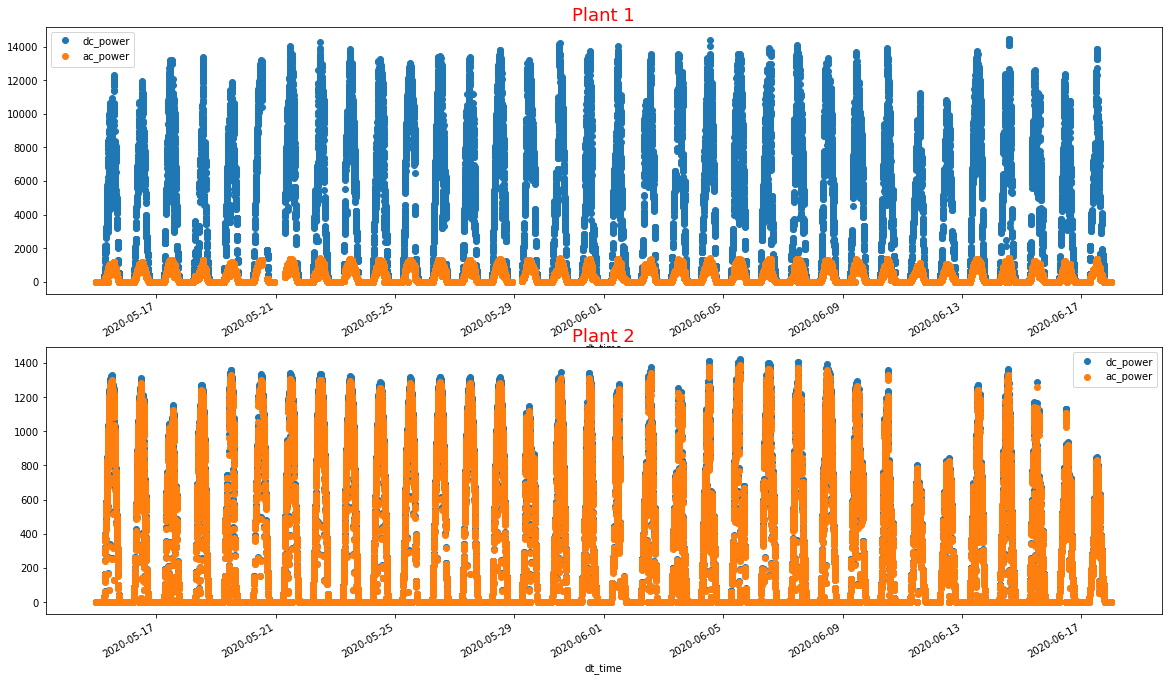

In [14]:
fig,ax = plt.subplots(2,1,figsize=(20,12))
plant2_generation.set_index('dt_time')[['dc_power','ac_power']].plot(style='o',ax=ax[1])
plant1_generation.set_index('dt_time')[['dc_power','ac_power']].plot(style='o',ax=ax[0])
ax[1].set_title('Plant 2',fontsize=18,color='red')
ax[0].set_title('Plant 1',fontsize=18, color='red')

Text(0.5, 1.0, 'Plant 1')

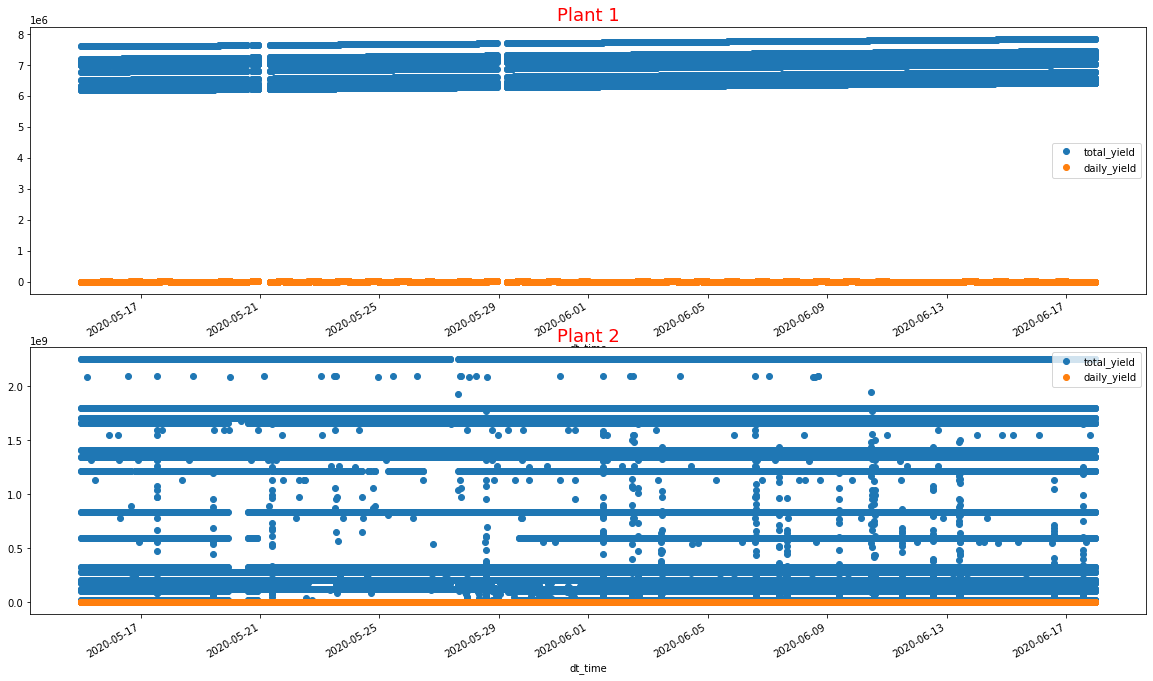

In [15]:
fig,ax = plt.subplots(2,1,figsize=(20,12))
plant2_generation.set_index('dt_time')[['total_yield','daily_yield']].plot(style='o',ax=ax[1])
plant1_generation.set_index('dt_time')[['total_yield','daily_yield']].plot(style='o',ax=ax[0])
ax[1].set_title('Plant 2',fontsize=18,color='red')
ax[0].set_title('Plant 1',fontsize=18, color='red')

# <font color='blue'> Counts of Source_Key /inverter 
    (that converts DC power generated by PV cells to AC powers that can transmit efficiently through long distance). 

In [16]:
print('Counts of source keys in plant1_generation')
print (plant1_generation.source_key.value_counts())
print('\n')
print('Counts of source keys in plant2_generation')
print (plant2_generation.source_key.value_counts())
print('\n')
print('Counts of source keys in plant1_weather')
print (plant1_weather.source_key.value_counts())
print('\n')
print('Counts of source keys in plant2_weather')
print (plant2_weather.source_key.value_counts())


Counts of source keys in plant1_generation
bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
7JYdWkrLSPkdwr4    3133
VHMLBKoKgIrUVDU    3133
ZnxXDlPa8U1GXgE    3130
ih0vzX44oOqAx2f    3130
z9Y9gH1T5YWrNuG    3126
wCURE6d3bPkepu2    3126
uHbuxQJl8lW7ozc    3125
pkci93gMrogZuBj    3125
iCRJl6heRkivqQ3    3125
rGa61gmuvPhdLxV    3124
sjndEbLyjtCKgGv    3124
McdE0feGgRqW7Ca    3124
zVJPv84UY57bAof    3124
ZoEaEvLYb1n2sOq    3123
1IF53ai7Xc0U56Y    3119
adLQvlD726eNBSB    3119
zBIq5rxdHJRwDNY    3119
WRmjgnKYAwPKWDb    3118
3PZuoBAID5Wc2HD    3118
YxYtjZvoooNbGkE    3104
Name: source_key, dtype: int64


Counts of source keys in plant2_generation
xoJJ8DcxJEcupym    3259
WcxssY2VbP4hApt    3259
9kRcWv60rDACzjR    3259
vOuJvMaM2sgwLmb    3259
rrq4fwE8jgrTyWY    3259
LYwnQax7tkwH5Cb    3259
LlT2YUhhzqhg5Sw    3259
q49J1IKaHRwDQnt    3259
oZZkBaNadn6DNKz    3259
PeE6FRyGXUgsRhN    3259
81aHJ1q11NBPMrL    3259
V94E5Ben1TlhnDV    3259
oZ35aAeoifZaQzV    3195
4UPUqMRk7TRMgml    3195
Qf4GUc1pJu5T6c6  

# Preparing to merge generation data with weather data

In [17]:
for i in dataframes:
    i["source_key"] =  i["source_key"].astype('category')
    i["simp_source"] = i["source_key"].cat.codes
    
plant1_generation['plant_id_new'] = 1
plant1_weather['plant_id_new'] = 1
plant2_generation['plant_id_new'] = 2
plant2_weather['plant_id_new'] = 2

for i in dataframes:
    i['plant_id_new'] = i['plant_id_new'].astype('string')
    i['simp_source'] = i['simp_source'].astype('string')
    i['plant_array'] = i['plant_id_new'] + '/' + i['simp_source']
    i['plant_id_new'] = i['plant_id_new'].astype('category')
    i['simp_source'] = i['simp_source'].astype('category')


In [18]:
print('dt_time.count in plant1_generation')
print (plant1_generation.dt_time.count())
print('\n')
print('dt_time.count in plant2_generation')
print (plant2_generation.dt_time.count())
print('\n')
print('dt_time.count in plant1_weather')
print (plant1_weather.dt_time.count())
print('\n')
print('dt_time.count in plant2_weather')
print (plant2_weather.dt_time.count())


dt_time.count in plant1_generation
68778


dt_time.count in plant2_generation
67698


dt_time.count in plant1_weather
3182


dt_time.count in plant2_weather
3259


# 3. Features

# Creating Dataframes with both generation and weather data

In [20]:
plant1 = pd.merge(plant1_generation, plant1_weather, how='inner', on = 'dt_time')
plant2 = pd.merge(plant2_generation, plant2_weather, how='inner', on = 'dt_time')

df = pd.concat([plant1,plant2], axis = 0)
df.head()

,dt_time,plant_id_x,source_key_x,dc_power,ac_power,daily_yield,total_yield,plant_id_new_x,plant_id_y,source_key_y,amb_temp,mod_temp,irrad,simp_source,plant_id_new_y,plant_array
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,1,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0,1,1/0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,1,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0,1,1/0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,1,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0,1,1/0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,1,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0,1,1/0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,1,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0,1,1/0


df = df[['dt_time',
        'plant_array_x',
        'dc_power',
        'ac_power',
       'daily_yield',
        'total_yield',
        'amb_temp',
        'mod_temp',
       'irrad',
        'simp_source_x',
        'plant_id_new_x']]
df.info()

In [23]:
df.head()

,dt_time,plant_id_x,source_key_x,dc_power,ac_power,daily_yield,total_yield,plant_id_new_x,plant_id_y,source_key_y,amb_temp,mod_temp,irrad,simp_source,plant_id_new_y,plant_array
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,1,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0,1,1/0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,1,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0,1,1/0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,1,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0,1,1/0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,1,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0,1,1/0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,1,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,0,1,1/0


inversion=plant1_generation.copy()
inversion['day']=inversion['dt_time'].dt.date
inversion=inversion.groupby('day').sum()
inversion['inversion']=inversion['ac_power']/inversion['dc_power']*100

inversion['inversion'].plot(style='o-',figsize=(17,5),label='Real Power')
plt.title('Plant1',fontsize=17)
plt.ylabel('inversion',fontsize=14,color='red')
plt.axhline(inversion['inversion'].mean(),linestyle='--',color='gray',label='mean')
plt.legend()
plt.show()

sources=plant1_generation.copy()
sources['time']=sources['dt_time'].dt.time
sources.set_index('time').groupby('source_key')['dc_power'].plot(style='o',legend=True,figsize=(20,10))
plt.title('DC Power',size=17)
plt.ylabel('kWatt',color='navy',fontsize=17)
plt.show()

df['dc_power','amb_temp'].plot(style='o',legend=True,figsize=(20,5))
plt.title('Plant2',size=17)
plt.ylabel('kWatt',color='navy',fontsize=17)
plt.show()

# Zero power generation

In [30]:
full = plant1.daily_yield.count() 
zeros = plant1.loc[plant1['daily_yield']==0].daily_yield.count()

print('plant 1 number of rows that is full or zero:', full,'and', zeros)
print ('plant 1 number of rows after removing zeros: ', full - zeros)
print ('plant 1 percentage of zeros: ', zeros / full)

plant 1 number of rows that is full or zero: 68774 and 18696
plant 1 number of rows after removing zeros:  50078
plant 1 percentage of zeros:  0.271846918893768


In [31]:
full = plant2.daily_yield.count() 
zeros = plant2.loc[plant2['daily_yield']==0].daily_yield.count()

print('plant 2 number of rows that is full or zero:', full,'and', zeros)
print ('plant 2 number of rows after removing zeros: ', full - zeros)
print ('plant 2 percentage of zeros: ', zeros / full)

plant 2 number of rows that is full or zero: 67698 and 11569
plant 2 number of rows after removing zeros:  56129
plant 2 percentage of zeros:  0.1708913114124494


In [32]:
plant2 = plant2.loc[plant2['daily_yield']!=0].copy()
plant2.reset_index(inplace = True)

In [33]:
plant2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56129 entries, 0 to 56128
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           56129 non-null  int64         
 1   dt_time         56129 non-null  datetime64[ns]
 2   plant_id_x      56129 non-null  int64         
 3   source_key_x    56129 non-null  object        
 4   dc_power        56129 non-null  float64       
 5   ac_power        56129 non-null  float64       
 6   daily_yield     56129 non-null  float64       
 7   total_yield     56129 non-null  float64       
 8   plant_id_new_x  56129 non-null  int64         
 9   plant_id_y      56129 non-null  int64         
 10  source_key_y    56129 non-null  category      
 11  amb_temp        56129 non-null  float64       
 12  mod_temp        56129 non-null  float64       
 13  irrad           56129 non-null  float64       
 14  simp_source     56129 non-null  category      
 15  pl

<AxesSubplot:title={'center':'Irradiation at Plant 1'}, xlabel='dt_time'>

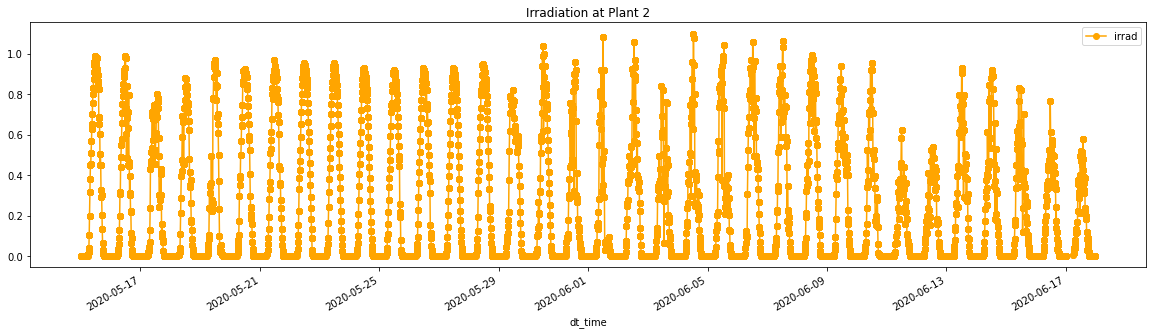

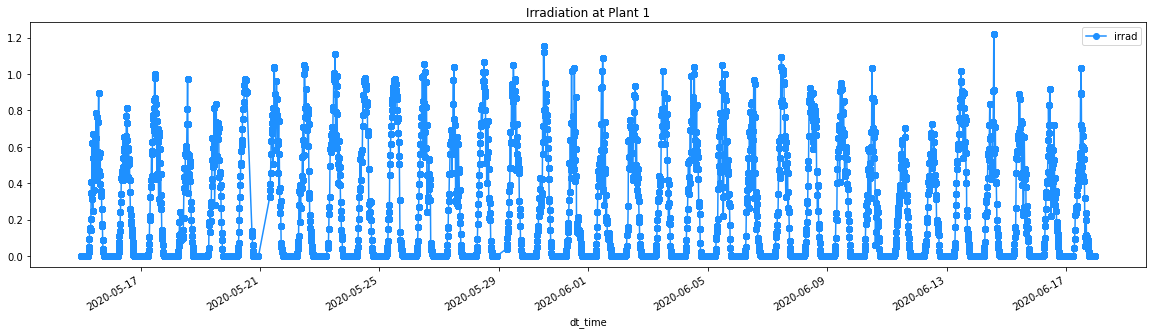

In [51]:
plant2.plot(x = 'dt_time', y = 'irrad', title='Irradiation at Plant 2', style='o-',figsize=(20,5), color='orange')
plant1.plot(x = 'dt_time', y = 'irrad', title='Irradiation at Plant 1', style='o-',figsize=(20,5), color='dodgerblue')

<AxesSubplot:title={'center':'amb_temp at Plant 1'}, xlabel='dt_time'>

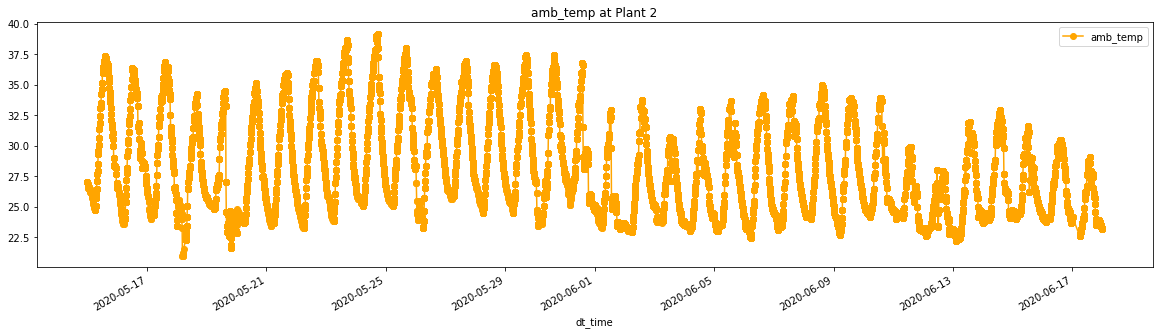

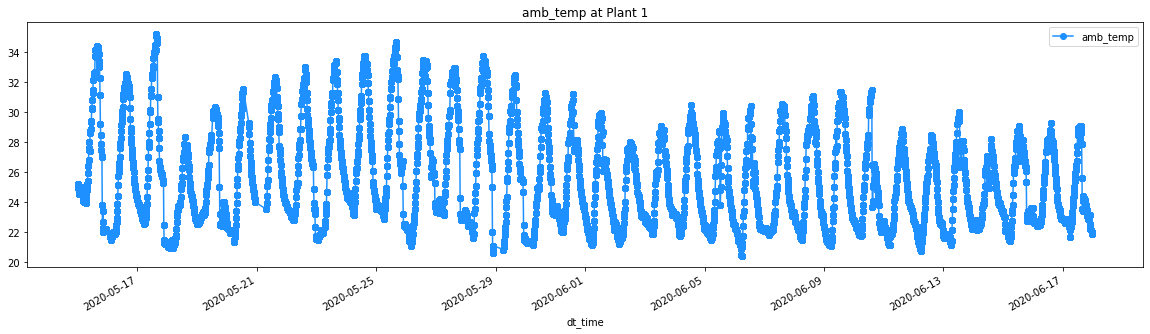

In [50]:
plant2.plot(x = 'dt_time', y = 'amb_temp', title='amb_temp at Plant 2', style='o-',figsize=(20,5), color='orange')
plant1.plot(x = 'dt_time', y = 'amb_temp', title='amb_temp at Plant 1', style='o-',figsize=(20,5), color='dodgerblue')

<AxesSubplot:title={'center':'dc_power at Plant 1'}, xlabel='dt_time'>

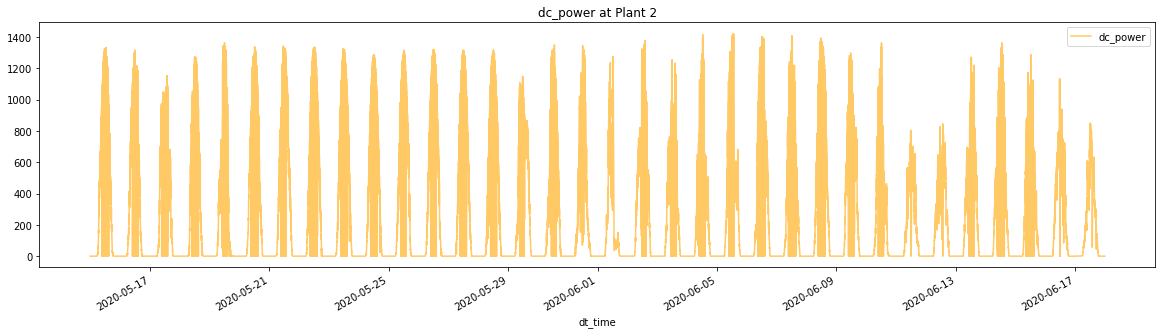

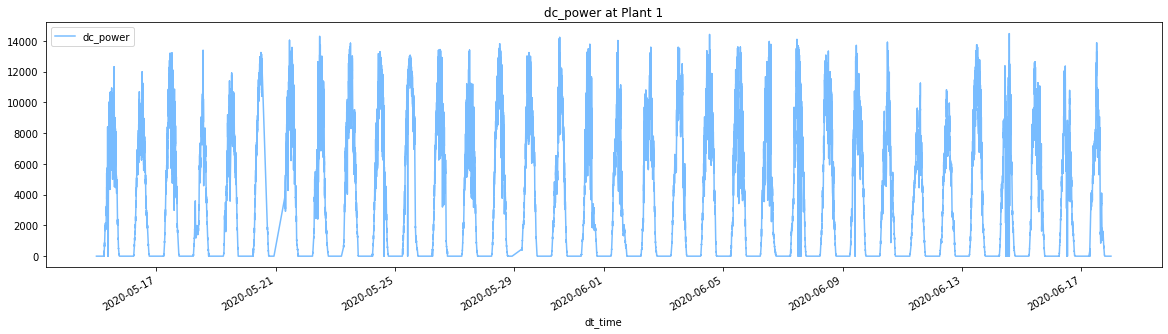

In [47]:
plant2.plot(x = 'dt_time', y = 'dc_power', title='dc_power at Plant 2', alpha=0.6,figsize=(20,5), color='orange')
plant1.plot(x = 'dt_time', y = 'dc_power', title='dc_power at Plant 1', alpha=0.6,figsize=(20,5), color='dodgerblue')

<AxesSubplot:title={'center':'ac_power vs amb_temp at Plant 1'}, xlabel='amb_temp'>

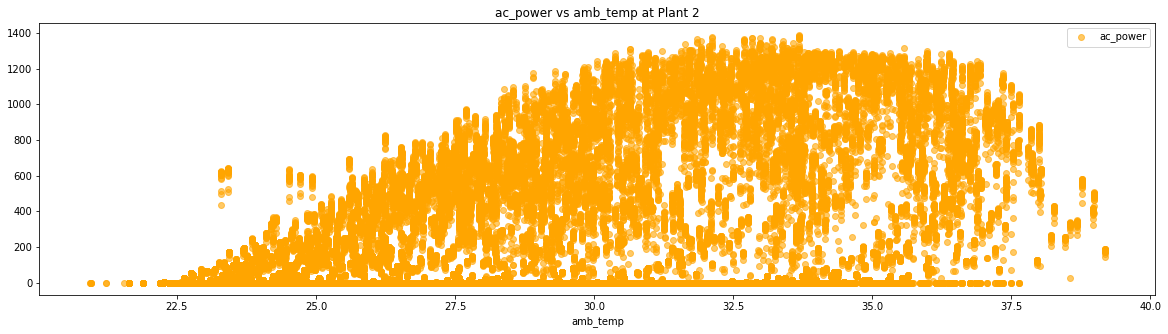

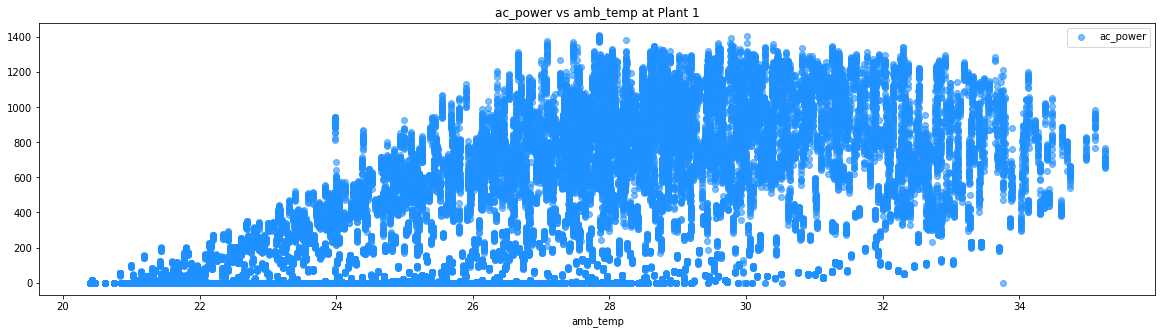

In [52]:
plant2.plot(x = 'amb_temp', y = 'ac_power', title='ac_power vs amb_temp at Plant 2', style='o',alpha=0.6,figsize=(20,5), color='orange')
plant1.plot(x = 'amb_temp', y = 'ac_power', title='ac_power vs amb_temp at Plant 1', style='o', alpha=0.6,figsize=(20,5), color='dodgerblue')

# Add a column for date


In [ ]:
df['date'] = pd.to_datetime(df['dt_time']).dt.date

# Define a  function for scatter plot

In [ ]:
def plot_scatter(df, feat_1, feat_2):
    plt.figure(figsize=(9,9))
    sns.scatterplot(data=df, x=feat_1, y = feat_2)
    #Title = f'{feat_1, feat_2}'
    #plt.title(Title, fontsize=15)
    plt.show()

# Visualizations

df1 = df.loc[df['ac_power'] > 0]

plot_scatter(df1, 'amb_temp', 'ac_power')
plot_scatter(df1, 'amb_temp', 'dc_power')

plot_scatter(df1, 'mod_temp', 'ac_power')
plot_scatter(df1, 'mod_temp', 'dc_power')

plot_scatter(df1, 'irrad', 'ac_power')
plot_scatter(df1, 'irrad', 'dc_power')

# Correlation map

def fancy_plot(df, method = 'pearson', annot = True, **kwargs):
    sns.clustermap(df.corr(method), vmin = -1.0, vmax = 1.0, cmap = 'icefire', method = 'complete', annot = annot, **kwargs)

fancy_plot(df)

In [ ]:
df.simp_source_x = df.simp_source_x.astype('category')
df.plant_id_new_x = df.plant_id_new_x.astype('category')

In [ ]:
df.corr()

# correlation with dc_power vs ac_power

In [ ]:
df1 = df.loc[df['dc_power']>0].copy()
df1 = df.loc[df['ac_power']>0].copy()
df1 = df1[['ac_power', 'dc_power', 'amb_temp', 'mod_temp', 'irrad', 'simp_source_x', 'plant_id_new_x']].copy()
print(df1.corr())

# 4. Predicting power output

# Define a function to plot predicted vs actual

In [ ]:
def plot_pred_actual_ac(y_pred, y_test, scale):
    predicted_value = y_pred
    true_value = y_test
    plt.figure(figsize=(10,5))
    plt.scatter(true_value, predicted_value, c='yellow')
    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    plt.plot([p1, p2],[p1, p2]) #, 'b-')
    plt.title = 'Predicting AC output'
    plt.xlabel('True AC Output', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    
def plot_pred_actual_dc(y_pred, y_test, scale):
    predicted_value = y_pred
    true_value = y_test
    plt.figure(figsize=(10,5))
    plt.scatter(true_value, predicted_value, c='green')
    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    plt.plot([p1, p2],[p1, p2]) #, 'b-')
    plt.title = 'Predicting DC output'
    plt.xlabel('True DC Output', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')

# linear regression to predict DC and AC output

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
def lin_reg_ac(X,y,test_size,scale):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=14)
    reg = LinearRegression().fit(X, y)
    pred = reg.predict(X_test)
    print ('AC rmse: ',mean_squared_error(y_test, pred, squared = False))
    print('AC r2: ', r2_score(y_test, pred))
    plot_pred_actual_ac(y_test, pred, scale)
    return pred

from sklearn.metrics import mean_squared_error,r2_score
def lin_reg_dc(X,y,test_size,scale):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=14)
    reg = LinearRegression().fit(X, y)
    pred = reg.predict(X_test)
    print ('DC rmse: ',mean_squared_error(y_test, pred, squared = False))
    print('DC r2: ', r2_score(y_test, pred))
    plot_pred_actual_dc(y_test, pred, scale)
    return pred

In [ ]:
X = df1[['amb_temp', 'mod_temp', 'irrad',
       'simp_source_x', 'plant_id_new_x']] #.copy().to_numpy()
y_ac = df1['ac_power']
y_dc = df1['dc_power']
pred_ac = lin_reg_ac(X,y_ac,10,'linear')
pred_dc = lin_reg_dc(X,y_dc,10,'linear')

# less features

In [ ]:
X = df1[['amb_temp', 'mod_temp', 'irrad']] 
y_ac = df1['ac_power']
y_dc = df1['dc_power']
pred_ac = lin_reg_ac(X,y_ac,10,'linear')
pred_dc = lin_reg_dc(X,y_dc,10,'linear')

# min max scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X = df1[['amb_temp', 'mod_temp', 'irrad',
       'simp_source_x', 'plant_id_new_x', 'ac_power']].copy().to_numpy()

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

y_ac = X[:,5]
X = X[:,0:5]


pred_ac2 = lin_reg_ac(X,y_ac,20,'linear')

## XGBoost


default parameters

In [ ]:
# Default paramaters for XHBoost, we will use Optuna to optimise these parameters later
# remember when putting a dictionary in a function you need to proceed it with **

xgb_params = dict(
    max_depth=3,                           # maximum depth of each tree - try 2 to 10
    learning_rate=000.1,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=200,                     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,                    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=1,   # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=1,          # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0,        # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1,         # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,                   # set > 1 for boosted random forests
)

Function to test the model with parameters

In [ ]:
# function to do some boosting

def xgb_score(X, y, model=XGBRegressor(**xgb_params)):
    
    #changing the categorical labels into numbers for the model
    for name in X.select_dtypes(['category']):
        X[name] = X[name].cat.codes
        
    #Changing y to a log, we will have to change it back before we submit exp
    y_log = np.log(y)
    
    score = cross_val_score(model,X, y_log, cv=5, scoring = 'neg_mean_squared_error')
    score = -1 *score.mean()
    score = np.sqrt(score)
    return(score)
    print(score)

Getting performance score benchmark

In [ ]:
# getting the score!

y_ac = df1['ac_power'].copy()
y_dc = df1['dc_power'].copy()
X = df1[['amb_temp', 'mod_temp', 'irrad', 'simp_source_x', 'plant_id_new_x']].copy()

xgb_score(X,y_dc, model=XGBRegressor(**xgb_params))

Getting the model to make predictions

In [ ]:
y_ac = df1['ac_power'].copy()
y_dc = df1['dc_power'].copy()
X = df1[['amb_temp', 'mod_temp', 'irrad', 'simp_source_x', 'plant_id_new_x']].copy()
for name in X.select_dtypes(['category']):
        X[name] = X[name].cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y_ac, test_size=0.5, random_state=8)

xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train, y_train)

Plotting model predictions

In [ ]:
y_ac_pred = xgb.predict(X_test)

print ('rmse: ',mean_squared_error(y_test, y_ac_pred, squared = False))
print('r2: ', r2_score(y_test, y_ac_pred))

plot_pred_actual_ac(y_test, y_ac_pred, 'linear')

## Tuning XGb regressor

In [ ]:
# # trial parameters telling optuna where to test, this will take a long time

# y_ac = df1['ac_power'].copy()
# y_dc = df1['dc_power'].copy()
# X = df1[['amb_temp', 'mod_temp', 'irrad', 'simp_source_x']].copy()

# def objective(trial):
#     xgb_params = dict(
#         max_depth=trial.suggest_int("max_depth", 2, 10),
#         learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
#         n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
#         min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
#         colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
#         subsample=trial.suggest_float("subsample", 0.2, 1.0),
#         reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
#         reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
#     )
#     xgb = XGBRegressor(**xgb_params)
    
#     return score_please(X_train, y_train, xgb)

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)
# xgb_params = study.best_params

Trial 49 finished with value: 0.16540890969688846 and parameters: {'max_depth': 8, 'learning_rate': 0.007370619279795246, 'n_estimators': 2222, 'min_child_weight': 7, 'colsample_bytree': 0.894850599575649, 'subsample': 0.8510498418045354, 'reg_alpha': 0.10371479505123118, 'reg_lambda': 0.10371479505123118}. Best is trial 48 with value: 0.1650462969089919.

In [ ]:
# parameters from the best performing test

xgb_params = dict(
    max_depth=8,                        
    learning_rate=0.007370619279795246,
    n_estimators=2222,
    min_child_weight=7,
    colsample_bytree=0.894850599575649,
    subsample=0.8510498418045354,
    reg_alpha=0.10371479505123118,
    reg_lambda=0.10371479505123118,
    num_parallel_tree=1,
)

In [ ]:
# y_ac = df1['ac_power'].copy()
# y_dc = df1['dc_power'].copy()
# X = df1[['amb_temp', 'mod_temp', 'irrad', 'simp_source_x', 'plant_id_new_x']].copy()

# score_please(X, y_ac, model=XGBRegressor(**xgb_params))

Making predictions with the new parameters and plotting the results

In [ ]:
y_ac = df1['ac_power'].copy()
y_dc = df1['dc_power'].copy()
X = df1[['amb_temp', 'mod_temp', 'irrad', 'simp_source_x', 'plant_id_new_x']].copy()
for name in X.select_dtypes(['category']):
        X[name] = X[name].cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y_ac, test_size=0.5, random_state=8)

xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train, y_train)

In [ ]:
y_ac_pred = xgb.predict(X_test)

print ('rmse: ',mean_squared_error(y_test, y_ac_pred, squared = False))
print('r2: ', r2_score(y_test, y_ac_pred))

plot_pred_actual_ac(y_test, y_ac_pred, 'linear')

# 5. Performance and Irradiation by Panel Arrays
Can we identify broken pannels, if any?
For arrays that are not working, their daily_yield would be lower than the average of the other arrays.
plan:

1. did any arrays produce zero output for any individual day?
3. how does each array performa compared to the plant average


In [ ]:
# sticking the two dataframes together and starting from scratch

plant1 = pd.merge(plant1_generation, plant1_weather, how='inner', on = 'dt_time')
plant2 = pd.merge(plant2_generation, plant2_weather, how='inner', on = 'dt_time')
df = pd.concat([plant1,plant2])
# re organising columns and removing extra columns
df = df[['dt_time',
        'plant_array_x',
        'dc_power',
        'ac_power',
       'daily_yield',
        'total_yield',
        'amb_temp',
        'mod_temp',
       'irrad',
        'simp_source_x',
        'plant_id_new_x']]
df['date'] = pd.to_datetime(df['dt_time']).dt.date
df.columns = ['dt', 'plant_array', 'dc_power', 'ac_power', 'daily_yield',
       'total_yield', 'amb_temp', 'mod_temp', 'irrad', 'array',
       'plant', 'date']

## Solar panels with zero output

In [ ]:
avg_period_power = df.pivot_table(index = ['plant', 'array'], columns = 'date', values = 'daily_yield', aggfunc = max)
avg_period_power.reset_index(inplace = True)



In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
avg_period_power['average_daily_power_yield'] = avg_period_power.iloc[:,-34:].mean(axis = 1).copy()

avg_period_power

above we can see that 2/4, 2/8, 2/14, 2/20 all generated no power from 21 - 28 May

Average perofmance of plant 1 arrays and plant 2 arrays

In [ ]:
# checking the average of all the arrays
avg_period_power.average_daily_power_yield.mean()


Lets seperate the plants, work out the mean daily yield per plant and check how each array performs against the mean

In [ ]:
def performance_to_mean (df ,plant, Title):
    
    array_monthly_average = df.loc[df['plant']==plant].copy()
    array_monthly_average = array_monthly_average[['plant','array', 'average_daily_power_yield']]
    avg = array_monthly_average['average_daily_power_yield'].mean()
    array_monthly_average['performance_%'] = ((array_monthly_average['average_daily_power_yield'] - avg) / avg) *100
    array_monthly_average.sort_values(by = 'performance_%', inplace=True)
    
    array_monthly_average.plot(x = 'array', y = 'performance_%', kind = 'barh', figsize = (10,10), title = Title, ylabel = '%' )  

#  Array performance as compared to plant average

In [ ]:
performance_to_mean(avg_period_power, '1', 'Plant 1 ')
performance_to_mean(avg_period_power, '2', 'Plant 2 ')

In [ ]:
df.head()
df['irrad_yield'] = df['daily_yield'] / df['irrad']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['irrad_yield'] = df['irrad_yield'].fillna(0)
df.irrad_yield.value_counts()

irrad_df = df.pivot_table(index = ['plant', 'array'], values = ['irrad_yield'], aggfunc = np.mean)
irrad_df.reset_index(inplace = True)
irrad_df = pd.DataFrame(data = irrad_df)


function to make performance chart

In [ ]:
def performance_to_mean_irrad (df,col,plant, Title):
    df[col] = df[col].round(2).copy()
    df.sort_values(col, inplace = True)
    df1 = df.loc[df['plant'] == plant].copy()
    avg = df1[col].mean()
    df1['performance_%'] = ((df1[col] - avg) / avg) *100
    return df1.plot(x = 'array', y = 'performance_%', kind = 'barh', figsize = (10,10), title = Title)
    
    
    

#  Array irradiation as compared to Plant average

In [ ]:
performance_to_mean_irrad(irrad_df, 'irrad_yield', '1', 'Plant 1 Irradiance to AC Power Production Compared to Plant Average')
performance_to_mean_irrad(irrad_df, 'irrad_yield', '2', 'Plant 1 Irradiance to AC Power Production Compared to Plant Average')

# Poor irradiation may suggest cleaning needs.
# Poor performance may suggest maintenance needs.

# Reference:

https://www.kaggle.com/code/tantable/solar-power-generation-data-work-in-progress

https://www.kaggle.com/code/virosky/how-to-manage-a-solar-power-plant